# This Notebook is used to Forecast Temperature from the Weather Dataset using different variations of LSTM. We will then export the predictions of validated data to our dashboard.

## Load Packages & Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import os
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from __future__ import print_function, division
from six import iteritems
%matplotlib inline
rcParams['figure.figsize'] = (13, 6)
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.optimizers import Adam, RMSprop, SGD, Adamax, Nadam, Adagrad, Adadelta
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load Datasets

### Electricity

In [ ]:
file_path = "/content/drive/MyDrive/AA USD/AAI 530 IOT/IOT Project /data/electricity_cleaned.csv"
df_electricity = pd.read_csv(file_path)
print(df_electricity.shape)

df_electricity['DateTime'] = pd.to_datetime(df_electricity['DateTime'])
df_electricity.set_index('DateTime', inplace=True)
df_electricity.head()

NameError: name 'pd' is not defined

In [ ]:
df_electricity['source'].unique()

array(['Electricity_I', 'Electricity_P', 'Electricity_Q', 'Electricity_S'],
      dtype=object)

In [ ]:
# Group the DataFrame by 'source' and create a separate DataFrame for each group
grouped = df_electricity.groupby('source')

# Creating a dictionary to hold each split DataFrame
dfs = {}
for name, group in grouped:
    dfs[name] = group

# Now, dfs is a dictionary where each key is a 'source' value and each value is the corresponding split DataFrame
# For example, to access the DataFrame for source 'Electricity_I', I can use:
df_electricity_i = dfs.get('Electricity_I')  # Replace 'Electricity_I' with the actual source name
df_electricity_p = dfs.get('Electricity_P')
df_electricity_q = dfs.get('Electricity_Q')
df_electricity_s = dfs.get('Electricity_S')

In [ ]:
df_electricity_p.head()

,source,WHE,RSE,GRE,MHE,B1E,BME,CWE,DWE,EQE,...,WOE,B2E,CDE,DNE,EBE,FGE,HTE,OUE,TVE,UNE
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-04-01 07:00:00,Electricity_P,96515.0,5636.0,94.0,90785.0,0.0,23180.0,0.0,0.0,2389.0,...,2.0,571.0,0.0,1463.0,0.0,2934.0,248.0,0.0,2259.0,6095.0
2012-04-01 08:00:00,Electricity_P,74729.0,5543.0,78.0,69108.0,0.0,409.0,0.0,0.0,2398.0,...,1.0,448.0,0.0,581.0,0.0,2674.0,300.0,0.0,2272.0,3865.0
2012-04-01 09:00:00,Electricity_P,75663.0,5681.0,84.0,69898.0,0.0,411.0,0.0,0.0,2397.0,...,3.0,439.0,0.0,51.0,0.0,1420.0,300.0,0.0,2266.0,4811.0
2012-04-01 10:00:00,Electricity_P,75980.0,5426.0,70.0,70484.0,0.0,411.0,0.0,0.0,2415.0,...,0.0,445.0,0.0,7.0,0.0,3506.0,300.0,0.0,2264.0,4622.0
2012-04-01 11:00:00,Electricity_P,84123.0,6065.0,72.0,77986.0,0.0,411.0,0.0,0.0,2391.0,...,2.0,450.0,0.0,3.0,0.0,2345.0,317.0,0.0,2260.0,4136.0


### Weather

In [ ]:
file_path = "/content/drive/MyDrive/AA USD/AAI 530 IOT/IOT Project /data/weather_cleaned.csv"
df_weather = pd.read_csv(file_path)

# Set Date/Time as indext and rename
df_weather['Date/Time'] = pd.to_datetime(df_weather['Date/Time'])
df_weather.set_index('Date/Time', inplace=True)
df_weather.index.rename('DateTime', inplace=True)


df_weather = df_weather[['Temp (C)']]
print(df_weather.shape)
df_weather.head()

(17520, 1)


,Temp (C)
DateTime,
2012-04-01 00:00:00,4.3
2012-04-01 01:00:00,4.4
2012-04-01 02:00:00,3.8
2012-04-01 03:00:00,2.8
2012-04-01 04:00:00,2.4


# Train on 2012 & 2013 and Test on 2014 ~ Ideal but actually used

Training set size: (15360, 1)
Test set size: (2160, 1)


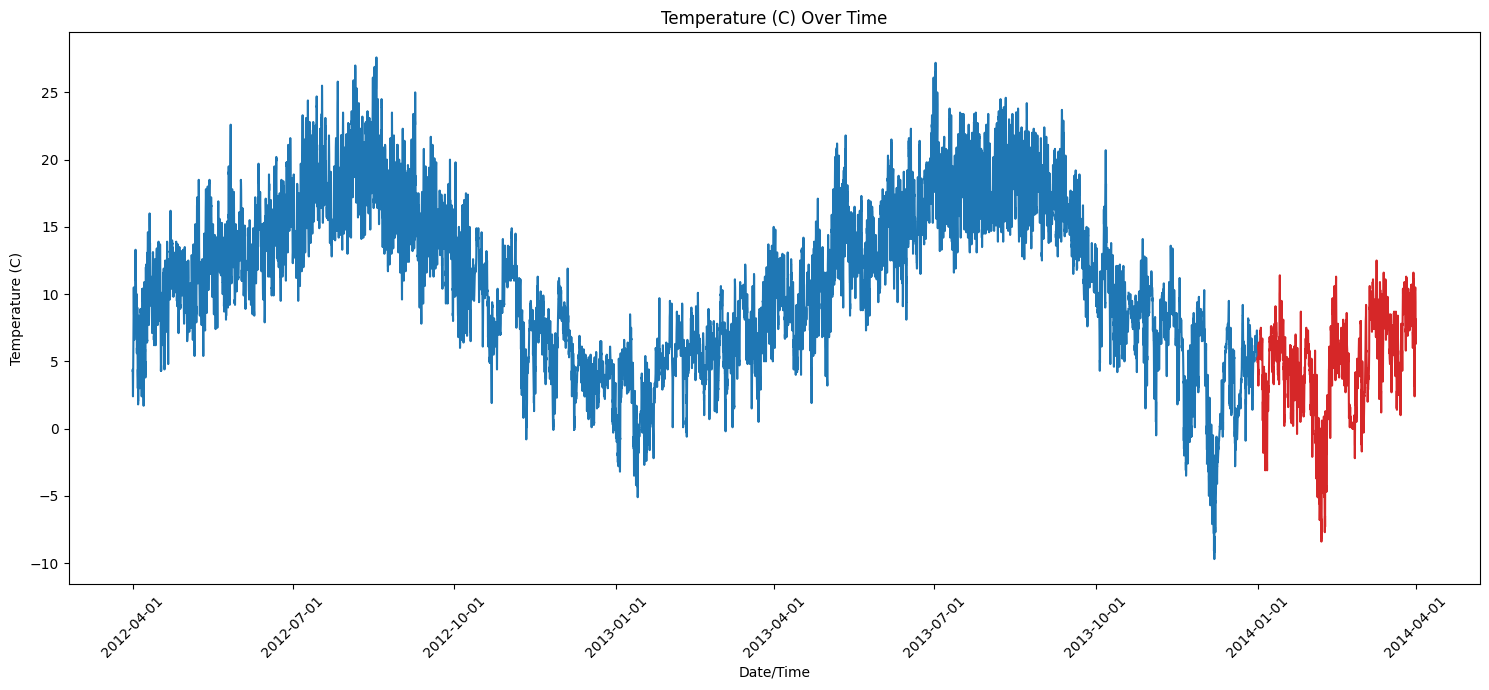

In [ ]:
# Filter data for training and test sets based on DateTime index
df_2013 = df_weather.loc[df_weather.index.year <= 2013]
df_2014 = df_weather.loc[df_weather.index.year >= 2014]

# Verify the shapes of the training and test sets
print("Training set size:", df_2013.shape)
print("Test set size:", df_2014.shape)


# Now, plot the 'Temp (C)' for Train & Validation
plt.figure(figsize=(15, 7))
plt.plot(df_2013.index, df_2013['Temp (C)'], color='tab:blue')
plt.plot(df_2014.index, df_2014['Temp (C)'], color='tab:red')
plt.title('Temperature (C) Over Time')
plt.xlabel('Date/Time')
plt.ylabel('Temperature (C)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.tight_layout()

# Append Datasets

In [ ]:
# Appending df_electricity_i to df_weather by matching DateTime indexes
df_appended = pd.concat([df_weather, df_electricity_i], axis=1, join='outer')
print(df_appended.shape)
df_appended.head(10)

(17527, 30)


,Rel Hum (%),Dew Point Temp (C),Stn Press (kPa),Wind Spd (km/h),Temp (C),Visibility (km),source,WHE,RSE,GRE,...,WOE,B2E,CDE,DNE,EBE,FGE,HTE,OUE,TVE,UNE
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-04-01 00:00:00,87.0,2.3,99.88,28.0,4.3,12.9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01 01:00:00,86.0,2.2,99.94,17.0,4.4,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01 02:00:00,86.0,1.6,100.00,26.0,3.8,6.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01 03:00:00,86.0,0.7,100.10,39.0,2.8,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01 04:00:00,87.0,0.4,100.23,30.0,2.4,9.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01 05:00:00,86.0,0.9,100.37,35.0,3.0,9.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01 06:00:00,87.0,1.7,100.55,30.0,3.7,12.9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01 07:00:00,79.0,1.3,100.74,24.0,4.7,16.1,Electricity_I,883.2,59.1,30.0,...,6.0,6.8,0.0,19.8,0.0,24.5,0.0,0.0,30.0,4.8
2012-04-01 08:00:00,75.0,1.3,100.94,20.0,5.3,24.1,Electricity_I,769.7,57.9,30.0,...,6.0,6.0,0.0,5.6,0.0,22.1,0.0,0.0,27.8,3.8


### Drop the NAN's as they we can't backfill the values here.

In [ ]:
df_cleaned = df_appended.dropna()
print(df_cleaned.shape)
df_cleaned.head()

(17448, 30)


,Rel Hum (%),Dew Point Temp (C),Stn Press (kPa),Wind Spd (km/h),Temp (C),Visibility (km),source,WHE,RSE,GRE,...,WOE,B2E,CDE,DNE,EBE,FGE,HTE,OUE,TVE,UNE
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-04-01 07:00:00,79.0,1.3,100.74,24.0,4.7,16.1,Electricity_I,883.2,59.1,30.0,...,6.0,6.8,0.0,19.8,0.0,24.5,0.0,0.0,30.0,4.8
2012-04-01 08:00:00,75.0,1.3,100.94,20.0,5.3,24.1,Electricity_I,769.7,57.9,30.0,...,6.0,6.0,0.0,5.6,0.0,22.1,0.0,0.0,27.8,3.8
2012-04-01 09:00:00,75.0,1.9,101.07,13.0,5.9,24.1,Electricity_I,707.0,59.2,30.0,...,6.0,6.0,0.0,0.0,0.0,11.5,0.0,0.0,28.8,5.6
2012-04-01 10:00:00,68.0,1.5,101.15,7.0,7.0,32.2,Electricity_I,709.8,56.6,30.0,...,6.0,6.0,0.0,0.0,0.0,29.1,0.0,0.0,27.9,5.3
2012-04-01 11:00:00,61.0,0.7,101.28,6.0,7.8,32.2,Electricity_I,782.0,61.9,30.0,...,6.0,6.0,0.0,0.0,0.0,19.1,0.2,0.0,28.3,3.7


In [ ]:
df_WHE = df_cleaned.drop(columns=['source','RSE', 'GRE', 'MHE', 'B1E', 'BME', 'CWE', 'DWE', 'EQE', 'FRE', 'HPE',
                                  'OFE', 'UTE', 'WOE', 'B2E', 'CDE', 'DNE', 'EBE', 'FGE', 'HTE', 'OUE','TVE', 'UNE'])
df_WHE.head(2)

,Rel Hum (%),Dew Point Temp (C),Stn Press (kPa),Wind Spd (km/h),Temp (C),Visibility (km),WHE
DateTime,,,,,,,
2012-04-01 07:00:00,79.0,1.3,100.74,24.0,4.7,16.1,883.2
2012-04-01 08:00:00,75.0,1.3,100.94,20.0,5.3,24.1,769.7


In [ ]:
df_RSE = df_cleaned.drop(columns=['source', 'WHE', 'GRE', 'MHE', 'B1E', 'BME', 'CWE', 'DWE', 'EQE', 'FRE', 'HPE',
                                  'OFE', 'UTE', 'WOE', 'B2E', 'CDE', 'DNE', 'EBE', 'FGE', 'HTE', 'OUE','TVE', 'UNE'])
df_RSE.head(2)

,Rel Hum (%),Dew Point Temp (C),Stn Press (kPa),Wind Spd (km/h),Temp (C),Visibility (km),RSE
DateTime,,,,,,,
2012-04-01 07:00:00,79.0,1.3,100.74,24.0,4.7,16.1,59.1
2012-04-01 08:00:00,75.0,1.3,100.94,20.0,5.3,24.1,57.9


In [ ]:
df_MHE = df_cleaned.drop(columns=['source', 'WHE','RSE', 'GRE', 'B1E', 'BME', 'CWE', 'DWE', 'EQE', 'FRE', 'HPE',
                                  'OFE', 'UTE', 'WOE', 'B2E', 'CDE', 'DNE', 'EBE', 'FGE', 'HTE', 'OUE','TVE', 'UNE'])
df_MHE.head(2)

,Rel Hum (%),Dew Point Temp (C),Stn Press (kPa),Wind Spd (km/h),Temp (C),Visibility (km),MHE
DateTime,,,,,,,
2012-04-01 07:00:00,79.0,1.3,100.74,24.0,4.7,16.1,794.1
2012-04-01 08:00:00,75.0,1.3,100.94,20.0,5.3,24.1,681.8


In [ ]:
df_UNE = df_cleaned.drop(columns=['source', 'WHE','RSE', 'GRE', 'MHE', 'B1E', 'BME', 'CWE', 'DWE', 'EQE', 'FRE', 'HPE',
                                  'OFE', 'UTE', 'WOE', 'B2E', 'CDE', 'DNE', 'EBE', 'FGE', 'HTE', 'OUE','TVE'])
df_UNE.head(2)

,Rel Hum (%),Dew Point Temp (C),Stn Press (kPa),Wind Spd (km/h),Temp (C),Visibility (km),UNE
DateTime,,,,,,,
2012-04-01 07:00:00,79.0,1.3,100.74,24.0,4.7,16.1,4.8
2012-04-01 08:00:00,75.0,1.3,100.94,20.0,5.3,24.1,3.8


# LSTM Model for WHE against Weather Data

We will split the data by 50% to match the electricity train & validation datasets.

## Split data, scale it and create train & validation sets

In [ ]:
df = df_weather['Temp (C)'].drop(columns=['DateTime'])
df.shape

#assign size for data subset
df_size = round(len(df)/2)
print(df_size)

start = 0
df_small = df.iloc[start:start+df_size].reset_index()

# Exclude non-numeric columns
numeric_columns = df_small.select_dtypes(include=[np.number]).columns

# Standardize the data
scaler = StandardScaler()
df_small[numeric_columns] = scaler.fit_transform(df_small[numeric_columns])

# Split data subset 80/20 for train/validation
split_point = round(len(df_small) * 0.8)
train_df = df_small.iloc[:split_point]
val_df = df_small.iloc[split_point:]

print("train size: ", train_df.shape)
print("validation size: ", val_df.shape)

print('Start Value: ',start)
#reset the indices for cleanliness
train_df = train_df.reset_index()
train_df = train_df.drop(columns=['DateTime'])

val_df = val_df.reset_index()
val_df = val_df.drop(columns=['DateTime'])

8760
train size:  (7008, 2)
validation size:  (1752, 2)
Start Value:  0


# Create Functions for Modeling
This function is used to convert the dataframe into sequences of data that the LSTM model can train on.

In [ ]:
seq_arrays = []
seq_labs = []


seq_length = 168
ph = 24
feat_cols = ['Temp (C)']

#create list of sequence length GAP readings
for start in range(0,len(train_df)-seq_length-ph):
  seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
  seq_labs.append(train_df['Temp (C)'].iloc[start+seq_length+ph-1]) # subtract 1 for zero-indexing

#convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length,len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))


In [ ]:
seq_arrays.shape

(6816, 168, 1)

In [ ]:
seq_labs.shape

(6816,)

In [ ]:
seq_labs[0]

-0.35643306

### Data Preprocessing

### Building the LSTM Model

In [ ]:
# # define path to save model
# model_path = 'LSTM_model1.h5'

# # build the network
# nb_features = len(feat_cols)
# nb_out = 1


# model = Sequential()

# #add first LSTM layer
# model.add(LSTM(
#          input_shape=(seq_length, nb_features),
#          units=5,
#          return_sequences=True))
# model.add(Dropout(0.3))

# # add second LSTM layer
# model.add(LSTM(
#           units=3,
#           return_sequences=False))
# model.add(Dropout(0.3))

# # Add the Dense layer with linear activation
# model.add(Dense(units=nb_out))
# model.add(Activation('linear'))

# optimizer = keras.optimizers.Adam(learning_rate = 0.001)
# # optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
# # optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
# model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

# print(model.summary())



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 168, 5)            140       
                                                                 
 dropout_15 (Dropout)        (None, 168, 5)            0         
                                                                 
 lstm_16 (LSTM)              (None, 3)                 108       
                                                                 
 dropout_16 (Dropout)        (None, 3)                 0         
                                                                 
 dense_6 (Dense)             (None, 1)                 4         
                                                                 
 activation_6 (Activation)   (None, 1)                 0         
                                                                 
Total params: 252 (1008.00 Byte)
Trainable params: 252

In [ ]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = len(feat_cols)
nb_out = 1

# Define the model
model = Sequential()

# Add the first LSTM layer with dropout
model.add(LSTM(units=128, return_sequences=True, input_shape=(seq_length, nb_features)))
model.add(Dropout(0.3))

# Add a second LSTM layer with dropout
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.3))

# Add a third LSTM layer with dropout
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.3))

# Add the Dense layer with linear activation
model.add(Dense(units=nb_out))
model.add(Activation('linear'))

optimizer = keras.optimizers.Adamax(learning_rate = 0.0001)
# optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
# optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 128)          66560     
                                                                 
 dropout (Dropout)           (None, 168, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 168, 64)           49408     
                                                                 
 dropout_1 (Dropout)         (None, 168, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [ ]:
# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=1000, batch_size=64, validation_split=0.05, verbose=2,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='min'),
                               keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

# List all data in history
print(history.history.keys())

Epoch 1/1000
102/102 - 11s - loss: 0.4363 - mse: 0.4363 - val_loss: 0.4819 - val_mse: 0.4819 - 11s/epoch - 110ms/step
Epoch 2/1000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


102/102 - 2s - loss: 0.2802 - mse: 0.2802 - val_loss: 0.3298 - val_mse: 0.3298 - 2s/epoch - 19ms/step
Epoch 3/1000
102/102 - 2s - loss: 0.2744 - mse: 0.2744 - val_loss: 0.3278 - val_mse: 0.3278 - 2s/epoch - 19ms/step
Epoch 4/1000
102/102 - 2s - loss: 0.2686 - mse: 0.2686 - val_loss: 0.3181 - val_mse: 0.3181 - 2s/epoch - 18ms/step
Epoch 5/1000
102/102 - 2s - loss: 0.2656 - mse: 0.2656 - val_loss: 0.2832 - val_mse: 0.2832 - 2s/epoch - 21ms/step
Epoch 6/1000
102/102 - 2s - loss: 0.2639 - mse: 0.2639 - val_loss: 0.2717 - val_mse: 0.2717 - 2s/epoch - 20ms/step
Epoch 7/1000
102/102 - 3s - loss: 0.2571 - mse: 0.2571 - val_loss: 0.2734 - val_mse: 0.2734 - 3s/epoch - 26ms/step
Epoch 8/1000
102/102 - 2s - loss: 0.2503 - mse: 0.2503 - val_loss: 0.2727 - val_mse: 0.2727 - 2s/epoch - 20ms/step
Epoch 9/1000
102/102 - 2s - loss: 0.2508 - mse: 0.2508 - val_loss: 0.2517 - val_mse: 0.2517 - 2s/epoch - 19ms/step
Epoch 10/1000
102/102 - 2s - loss: 0.2461 - mse: 0.2461 - val_loss: 0.2680 - val_mse: 0.2680 

### Evaluate

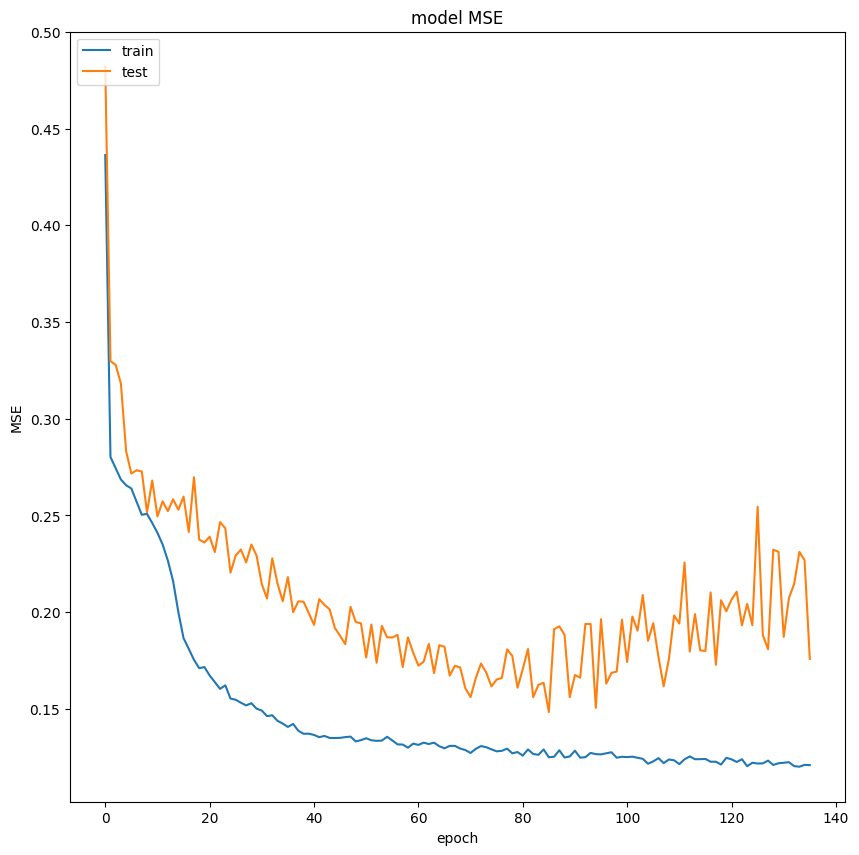

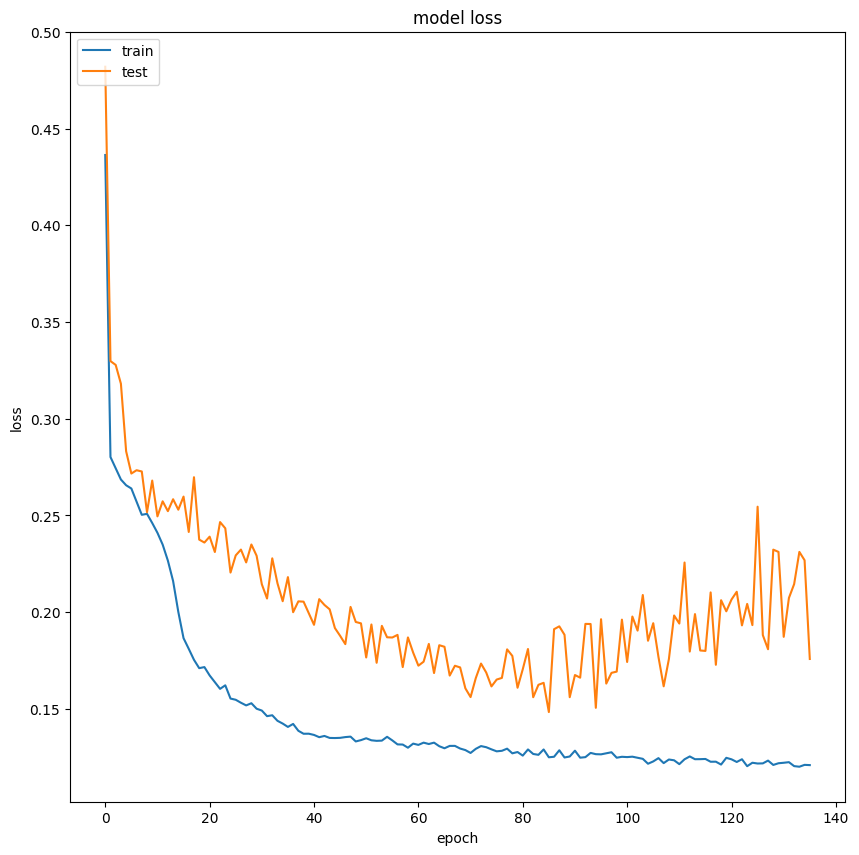

In [ ]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

In [ ]:
# Evaluate the model on the validation data
val_arrays = []
val_labs = []

# Create list of readings starting with a minimum of two readings
for i in range(2, len(val_df) - ph + 1):
    # Correctly reference the single column and convert it to a list
    input_seq = val_df[feat_cols].iloc[i - 2:i + seq_length - ph].to_numpy().tolist()
    # Ensure we have a label available at the predictive horizon
    if i + seq_length - ph <= len(val_df):
        label = val_df[feat_cols].iloc[i + seq_length - ph - 1]
        val_labs.append(label)
        val_arrays.append(input_seq)

# Use the pad_sequences function on your input sequences
# Remember that we will later want our datatype to be np.float32
# Pad sequences to ensure uniform length, using 'pre' padding
val_arrays_padded = pad_sequences(val_arrays, maxlen=seq_length, dtype='float32', padding='pre', value=0.0)
val_arrays = val_arrays_padded

# Convert labels to numpy arrays and floats
val_labs = np.array(val_labs, dtype=np.float32)

In [ ]:
val_labs.shape

(1607, 1)

In [ ]:
val_arrays.shape

(1607, 168, 1)

In [ ]:

# Evaluate the model on the validation data
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

# Predictions on validation data
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

# Rescale the predicted and true values back to the original scale
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test)
y_true_test_rescaled = scaler.inverse_transform(y_true_test)




# Save predictions to CSV
test_set = pd.DataFrame({'Predictions': y_pred_test_rescaled.flatten()})
test_set.to_csv('submit_test.csv', index=None)


51/51 - 2s - loss: nan - mse: nan - 2s/epoch - 33ms/step

MSE: nan
51/51 [==============================] - 1s 8ms/step


In [ ]:
y_pred_test_rescaled.shape

(1607, 1)

In [ ]:
y_true_test_rescaled.shape

(1607, 1)

## Evalutation

AAfter checking the validation results above, there seems to be missing data used within the validation set. Below I look for Indices with Null values, filtered them out and the rechecked the MSE. Despite the chart Below predicting the first and last 500 datapoints not having any missing values, I couldn't pinpoint why the validation above wasn't working.

In [ ]:
# Find indices where predictions are not NaN
not_nan_indices = ~np.isnan(y_pred_test_rescaled).flatten()

# Now, filter out NaN predictions and their corresponding true values
y_pred_test_filtered = y_pred_test_rescaled[not_nan_indices]
y_true_test_filtered = y_true_test_rescaled[not_nan_indices]

# Now you can compute MSE on the filtered arrays
mse = np.mean((y_pred_test_filtered - y_true_test_filtered) ** 2)
print('Filtered MSE:', mse)

Filtered MSE: 2.2325637


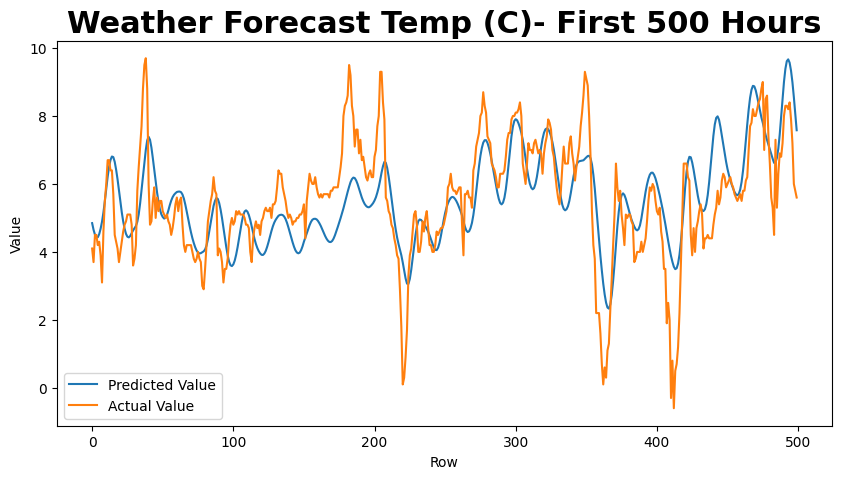

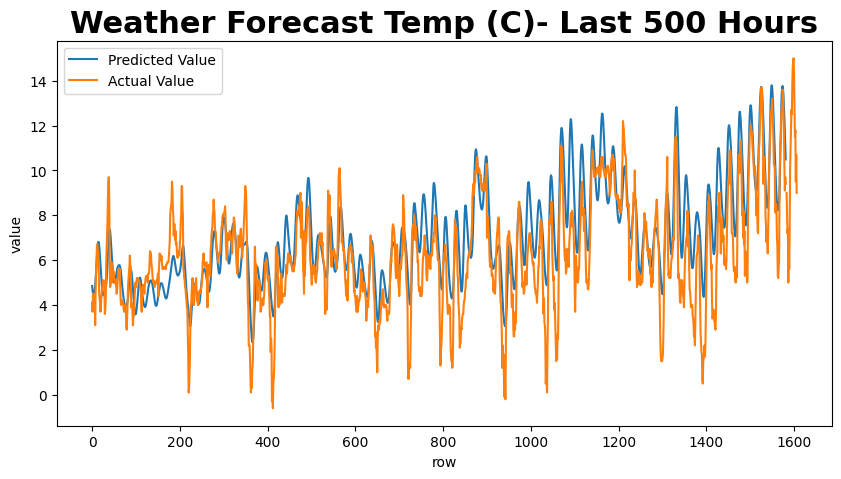

In [ ]:
# Plot the predicted data vs. the actual data
# we will limit our plot to the first and last 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test_rescaled[:500], label='Predicted Value')
plt.plot(y_true_test_rescaled[:500], label='Actual Value')
plt.title('Weather Forecast Temp (C)- First 500 Hours', fontsize=22, fontweight='bold')
plt.ylabel('Value')
plt.xlabel('Row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")


fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test_rescaled[:], label = 'Predicted Value')
plt.plot(y_true_test_rescaled[:], label = 'Actual Value')
plt.title('Weather Forecast Temp (C)- Last 500 Hours', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

#### We will rescale our data and the combine them into a combined datframe for our dashboard

In [ ]:
# Inverse transform to rescale the data back to the original scale
train_rescaled = scaler.inverse_transform(train_df)
val_rescaled = scaler.inverse_transform(val_df)

# Convert the rescaled arrays back to DataFrames
train_rescaled_df = pd.DataFrame(train_rescaled, columns=['DateTime','Temp (C)'])
val_rescaled_df = pd.DataFrame(val_rescaled, columns=['DateTime','Temp (C)'])

# Concatenate the rescaled train and validation dataframes
df_combined = pd.concat([train_rescaled_df, val_rescaled_df])

# Recreate the DateTime index for the combined dataframe
# This assumes your data was hourly and the first DateTime was '2012-04-01 07:00:00'
start_datetime = pd.to_datetime('2012-04-01 07:00:00')
date_range = pd.date_range(start=start_datetime, periods=len(df_combined), freq='H')

# Assign the DateTime to the combined dataframe
df_combined['DateTime'] = date_range
df_combined.set_index('DateTime', inplace=True)


In [ ]:
df_combined.shape

(8760, 1)

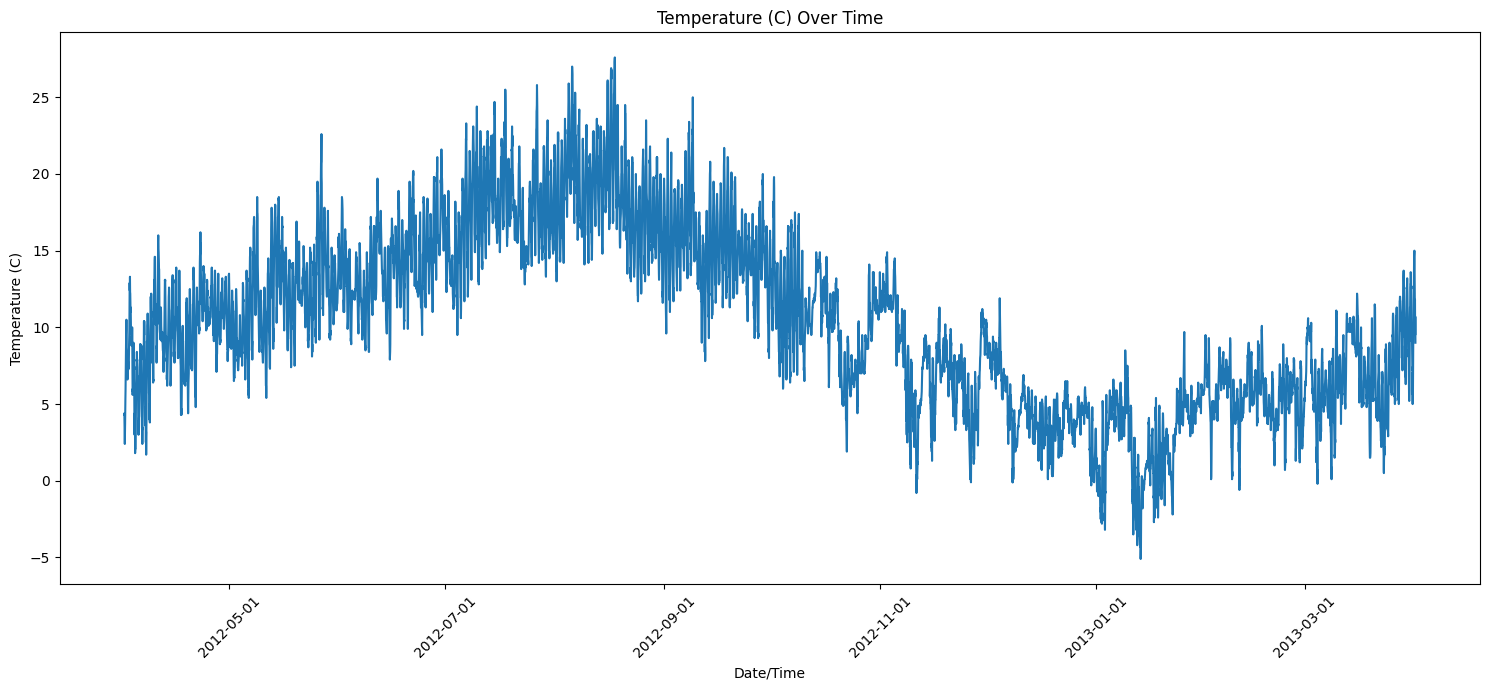

In [ ]:
# Now, plot the 'Temp (C)' for whole dataset
plt.figure(figsize=(15, 7))
plt.plot(df_combined.index, df_combined['Temp (C)'], color='tab:blue')

plt.title('Temperature (C) Over Time')
plt.xlabel('Date/Time')
plt.ylabel('Temperature (C)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.tight_layout()

# Rebuild Dataframe with Original and Validation

In [ ]:
# Predictions on validation data
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

# Rescale the predicted and true values back to the original scale
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test)
y_true_test_rescaled = scaler.inverse_transform(y_true_test)

51/51 [==============================] - 1s 14ms/step


In [ ]:
y_pred_test_rescaled.shape

(1607, 1)

In [ ]:
predictions = model.predict(val_arrays)

# Inverse scale the predictions
predictions_rescaled = scaler.inverse_transform(predictions)

# Create a DataFrame for the rescaled predictions
predictions_df = pd.DataFrame(predictions_rescaled, columns=['Predictions'])

# Determine the correct indices in df_combined for the predictions
# We align these from the end of the df_combined DataFrame
prediction_indices = df_combined.index[-len(predictions_df):]

# Assign these indices to the predictions DataFrame
predictions_df.index = prediction_indices

# Append the predictions DataFrame to the df_combined DataFrame
# Since you're appending from the end, you need to ensure the indices match correctly
df_combined.loc[predictions_df.index, 'Predictions'] = predictions_df['Predictions']

51/51 [==============================] - 1s 12ms/step


In [ ]:
prediction_indices

DatetimeIndex(['2013-01-24 08:00:00', '2013-01-24 09:00:00',
               '2013-01-24 10:00:00', '2013-01-24 11:00:00',
               '2013-01-24 12:00:00', '2013-01-24 13:00:00',
               '2013-01-24 14:00:00', '2013-01-24 15:00:00',
               '2013-01-24 16:00:00', '2013-01-24 17:00:00',
               ...
               '2013-03-31 21:00:00', '2013-03-31 22:00:00',
               '2013-03-31 23:00:00', '2013-04-01 00:00:00',
               '2013-04-01 01:00:00', '2013-04-01 02:00:00',
               '2013-04-01 03:00:00', '2013-04-01 04:00:00',
               '2013-04-01 05:00:00', '2013-04-01 06:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=1607, freq=None)

In [ ]:
df_combined

,Temp (C),Predictions
DateTime,,
2012-04-01 07:00:00,4.3,NaN
2012-04-01 08:00:00,4.4,NaN
2012-04-01 09:00:00,3.8,NaN
2012-04-01 10:00:00,2.8,NaN
2012-04-01 11:00:00,2.4,NaN
...,...,...
2013-04-01 02:00:00,11.5,NaN
2013-04-01 03:00:00,11.8,NaN
2013-04-01 04:00:00,9.5,NaN


# Export our combine dataframe for the Dashboard

In [ ]:
# Save the df_combined DataFrame to a CSV file
df_combined.to_csv("df_combined.csv", index=True)


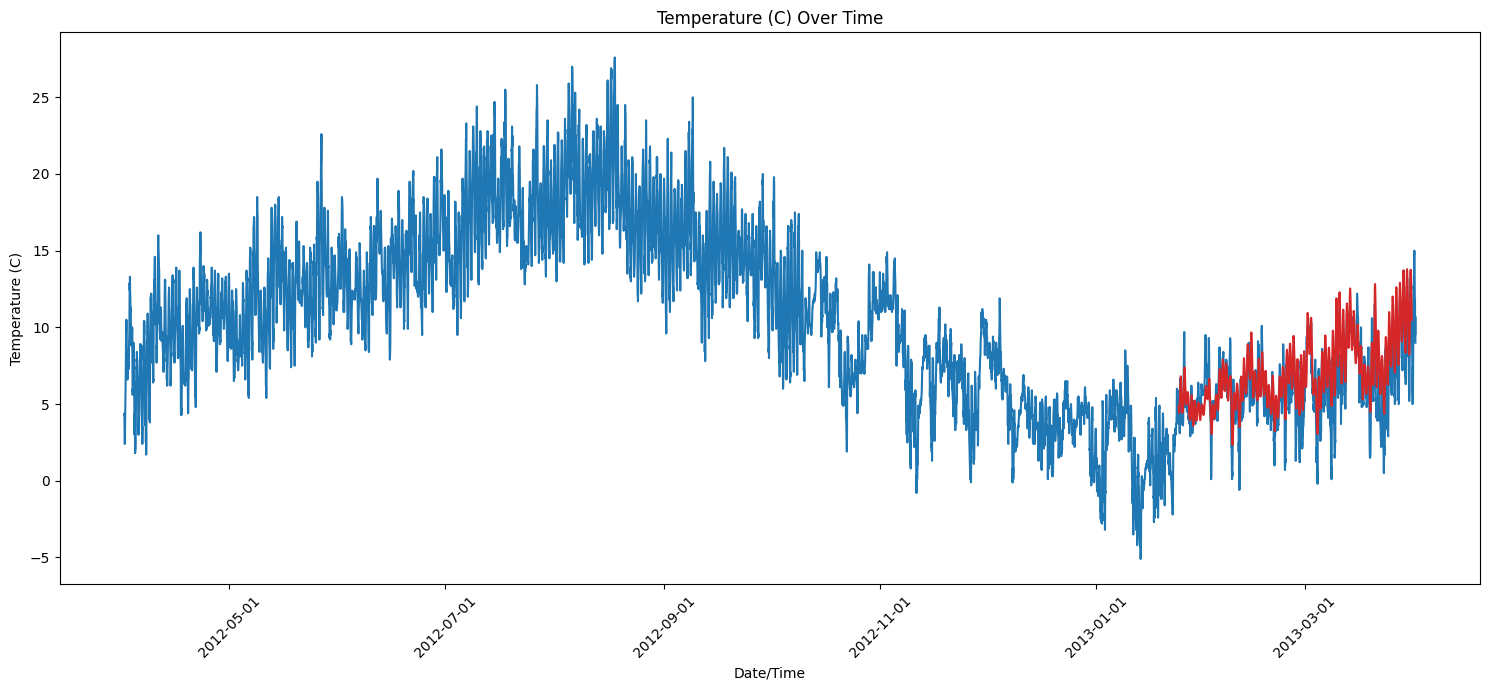

In [ ]:
# Now, plot the 'Temp (C)' for Train & Validation
plt.figure(figsize=(15, 7))
plt.plot(df_combined.index, df_combined['Temp (C)'], color='tab:blue')
plt.plot(df_combined.index, df_combined['Predictions'], color='tab:red')
plt.title('Temperature (C) Over Time')
plt.xlabel('Date/Time')
plt.ylabel('Temperature (C)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.tight_layout()